<a href="https://colab.research.google.com/github/sesburg/KaggleCompetitions/blob/main/Tabular_Playground_Series_Sep_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! kaggle competitions download -c tabular-playground-series-sep-2022

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
tabular-playground-series-sep-2022.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
! unzip tabular-playground-series-sep-2022.zip

Archive:  tabular-playground-series-sep-2022.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ㅜ
error:  invalid response [ㅜ]
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ㅜ
error:  invalid response [ㅜ]
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [3]:
import torch
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import cv2
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [5]:
train = train.set_index('row_id')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70128 entries, 0 to 70127
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      70128 non-null  object
 1   country   70128 non-null  object
 2   store     70128 non-null  object
 3   product   70128 non-null  object
 4   num_sold  70128 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.2+ MB


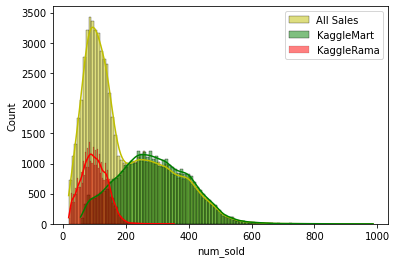

In [6]:
sns.histplot(train['num_sold'], kde = True, color = 'y', label = 'All Sales')
sns.histplot(train[train['store'] == 'KaggleMart']['num_sold'], color='g', kde= True, label = 'KaggleMart')
sns.histplot(train[train['store'] == 'KaggleRama']['num_sold'], color='r', kde= True, label = 'KaggleRama')
plt.legend()

In [7]:
train.groupby('country')['num_sold'].describe()

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Belgium,11688.0,237.940623,136.920137,50.0,121.0,194.0,349.25,925.0
France,11688.0,214.948580,123.639291,46.0,110.0,176.0,316.00,804.0
Germany,11688.0,238.399641,137.825036,48.0,121.0,194.0,351.00,986.0
Italy,11688.0,188.320671,110.882770,43.0,95.0,155.0,275.00,728.0
Poland,11688.0,114.779689,96.989212,19.0,46.0,90.0,140.00,761.0
Spain,11688.0,171.392710,103.572235,38.0,85.0,143.0,245.00,711.0


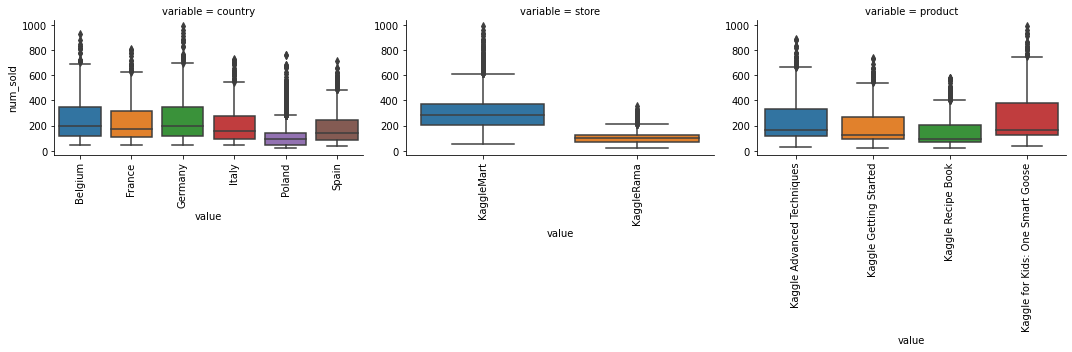

In [8]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['num_sold'], value_vars=['country', 'store', 'product'])
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, height=5)
g = g.map(boxplot, "value", "num_sold")

In [9]:
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['weekday'] = train['date'].dt.weekday
train.head()

,date,country,store,product,num_sold,year,month,day,weekday
row_id,,,,,,,,,
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663,2017,1,1,6
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615,2017,1,1,6
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480,2017,1,1,6
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710,2017,1,1,6
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240,2017,1,1,6


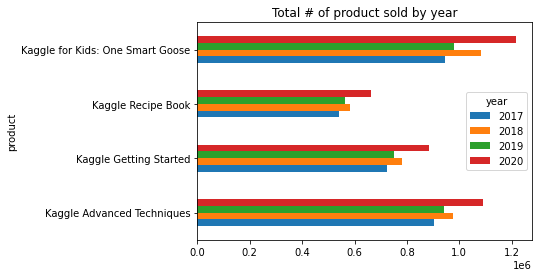

In [10]:
df1 = train.groupby(['product','year']).num_sold.sum().unstack()
df1.plot(kind='barh', title='Total # of product sold by year')

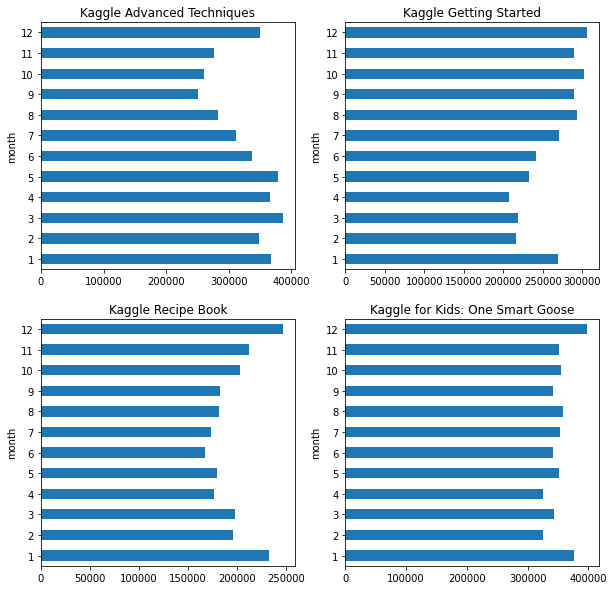

In [11]:
books = train['product'].unique()
plt.figure(figsize=(10, 10))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  df = train.groupby(['product']).get_group(books[i]).groupby(['month']).num_sold.sum()
  df.plot(kind= 'barh', title=books[i])

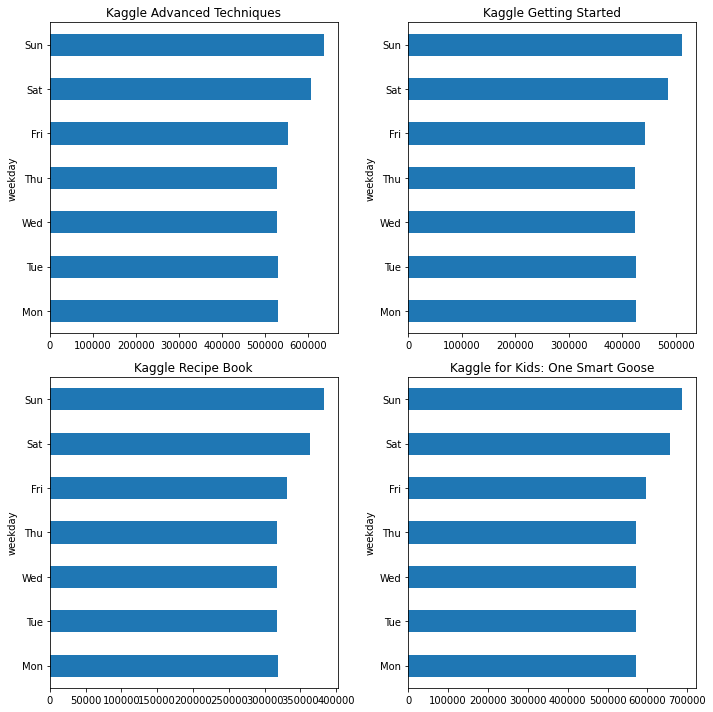

In [12]:
day_name = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(10, 10))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  df = train.groupby(['product']).get_group(books[i]).groupby(['weekday']).num_sold.sum()
  df.plot(kind= 'barh', title=books[i])
  ax.set_yticks(range(7))    
  ax.set_yticklabels(day_name)
  plt.tight_layout()

In [13]:
from sklearn.preprocessing import LabelEncoder

features = ['country','store', 'product', 'year', 'month', 'weekday']
lbl_encoders={}
for feature in features:
    lbl_encoders[feature]=LabelEncoder()
    train[feature]=lbl_encoders[feature].fit_transform(train[feature])

In [14]:
feat = np.stack([train[col] for col in features],1)
X = torch.tensor(feat, dtype=torch.int64)
y = torch.tensor(train['num_sold'].values,dtype=torch.float).reshape(-1,1)

In [15]:
dims=[len(train[col].unique()) for col in features]
dims

[6, 2, 4, 4, 12, 7]

In [16]:
embedding_dims=[(x,min(50,(x+1)//2)) for x in dims]
embedding_dims

[(6, 3), (2, 1), (4, 2), (4, 2), (12, 6), (7, 4)]

In [17]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
class FeedForwardNN(nn.Module):
    
    def __init__(self,embedding_dims, out_sz,layers,p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dims])
        self.emb_drop = nn.Dropout(p)
        
        layerlist=[]
        n_emb= sum(out for inp,out in embedding_dims)                    ### calculate the total dimension of embedding layer
        n_in= n_emb
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in=i

        layerlist.append(nn.Linear(layers[-1],out_sz))        
        self.layers=nn.Sequential(*layerlist)
     
    def forward(self, data):
        embeddings=[]
        for i,e in enumerate(self.embeds):
            embeddings.append(e(data[:,i]))
        x= torch.cat(embeddings,1)                      ## concatinating the embeddings and applying Dropout
        x= self.emb_drop(x)
        x= self.layers(x)
        return x

In [18]:
torch.manual_seed(100)
model=FeedForwardNN(embedding_dims, 1,[32, 64],p=0.1)
model

FeedForwardNN(
  (embeds): ModuleList(
    (0): Embedding(6, 3)
    (1): Embedding(2, 1)
    (2): Embedding(4, 2)
    (3): Embedding(4, 2)
    (4): Embedding(12, 6)
    (5): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.1, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [19]:
loss_func= nn.MSELoss()       ## Convert into RMSE later
optimizer= torch.optim.Adam(model.parameters(),lr=0.1)

In [20]:
train_size = round(len(X) * 0.2)
val_size = len(X) - train_size
Z = torch.cat([X, y], dim=1).to(torch.int64)
Z_train, Z_val = torch.utils.data.random_split(Z, [train_size, val_size], generator=torch.Generator().manual_seed(42))
X_train, y_train = Z_train.dataset[:,:(-1)], Z_train.dataset[:,-1].to(torch.float32).reshape(-1, 1)
X_val, y_val = Z_val.dataset[:, :-1], Z_val.dataset[:, -1].to(torch.float32).reshape(-1, 1)

In [21]:
epochs=3000
final_losses=[]
for i in range(epochs):
    i=i+1
    y_pred= model(X_train)
    loss= torch.sqrt(loss_func(y_pred, y_train))   ## RMSE
    final_losses.append(loss)
    if i%100==1:
        print("Epoch number: {} and the Loss: {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()         ##back propogation
    optimizer.step()

Epoch number: 1 and the Loss: 232.06097412109375
Epoch number: 101 and the Loss: 46.21793746948242
Epoch number: 201 and the Loss: 45.038475036621094
Epoch number: 301 and the Loss: 44.28152084350586
Epoch number: 401 and the Loss: 43.921653747558594
Epoch number: 501 and the Loss: 43.963104248046875
Epoch number: 601 and the Loss: 44.213130950927734
Epoch number: 701 and the Loss: 43.33417510986328
Epoch number: 801 and the Loss: 43.03109359741211
Epoch number: 901 and the Loss: 43.36614227294922
Epoch number: 1001 and the Loss: 43.244895935058594
Epoch number: 1101 and the Loss: 43.02479934692383
Epoch number: 1201 and the Loss: 42.81754684448242
Epoch number: 1301 and the Loss: 43.29337692260742
Epoch number: 1401 and the Loss: 43.26735305786133
Epoch number: 1501 and the Loss: 43.314720153808594
Epoch number: 1601 and the Loss: 43.042510986328125
Epoch number: 1701 and the Loss: 42.90868377685547
Epoch number: 1801 and the Loss: 42.65352249145508
Epoch number: 1901 and the Loss: 42

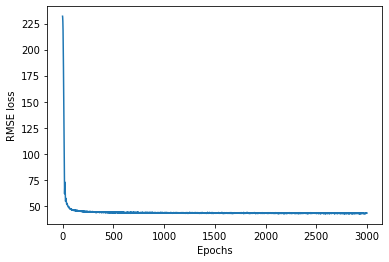

In [22]:
final_losses_detach = list(map(lambda x: x.detach(), final_losses ))
plt.plot(range(epochs),final_losses_detach)
plt.ylabel('RMSE loss')
plt.xlabel('Epochs');

In [23]:
y_pred=""
with torch.no_grad():
    y_pred= model(X_val)
    loss=torch.sqrt(loss_func(y_pred,y_val))
    
print("RMSE: {}" .format(loss))

RMSE: 42.58961486816406


In [24]:
torch.save(model,'HousePrice.pt')
torch.save(model.state_dict,'HouseWeights.pt') 

In [29]:
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['weekday'] = test['date'].dt.weekday

for feature in features:
    test[feature]=lbl_encoders[feature].fit_transform(test[feature])
ready_test = np.stack([test[col] for col in features],1)
ready_test = torch.tensor(ready_test, dtype=torch.int64)
final_pred = model(ready_test)

In [45]:
final_pred_no_grad = list(map(lambda x: x.detach().item(), final_pred ))
res = list(map(round, final_pred_no_grad))

In [48]:
output = pd.DataFrame({'row_id': test.row_id,
                       'num_sold': res})
output.to_csv('submission.csv', index=False)